# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
#Импортируем библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import time
import numpy as np
import lightgbm as lgb
import lightgbm as lgm

In [2]:
#Игнорируем предупреждения
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Добавим необходимые библиотеки 
from scipy.stats import norm
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import SGDRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import roc_curve, roc_auc_score, r2_score, mean_absolute_error, make_scorer

In [4]:
df = pd.read_csv('/datasets/autos.csv')

In [5]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
df['DateCreated'].describe()

count                  354369
unique                    109
top       2016-04-03 00:00:00
freq                    13719
Name: DateCreated, dtype: object

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [8]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [9]:
#Переименуем столбцы датасета

df.rename(columns={'DateCrawled': 'date_crawled', 
                         'Price': 'price',
                         'VehicleType': 'vehicle_type',
                         'RegistrationYear': 'reg_year',
                         'Gearbox': 'gearbox',
                         'Power': 'power',
                         'Model': 'model',
                         'Kilometer': 'kilometer',
                         'RegistrationMonth': 'reg_month',
                         'FuelType': 'fuel_type',
                         'Brand': 'brand',
                         'Repaired': 'not_repaired',
                         'DateCreated': 'date_created',
                         'NumberOfPictures': 'num_photo',
                         'PostalCode': 'postal_code',
                         'LastSeen': 'last_seen'
                        }, inplace=True)

In [10]:
#Удалим не нужные столбцы

df.drop('date_created', axis=1, inplace=True)
df.drop('last_seen', axis=1, inplace=True)
df.drop('num_photo', axis=1, inplace=True)
df.drop('postal_code', axis=1, inplace=True)
df.drop('date_crawled', axis=1, inplace=True)
df.drop('reg_month', axis=1, inplace=True)

*Обработаем дубликаты и пропуски*

In [11]:
#Проверим данные на наличие дубликатов

print('Количество дубликатов', df.duplicated().sum())

Количество дубликатов 45040


In [12]:
# удалим дубликаты
df = df.drop_duplicates()

In [13]:
#Проверим данные на пропуски
df.isna().sum()

price               0
vehicle_type    34559
reg_year            0
gearbox         17207
power               0
model           18361
kilometer           0
fuel_type       30764
brand               0
not_repaired    64558
dtype: int64

In [14]:
#Обработаем пропуски 

# Замена сделана таким образом, т.к. автомобиль чаще не был в ремонте
df['not_repaired'].fillna('no', inplace=True)
#данная категория, как раз обозначает тип авто,который не определен, что нам полностью подходит. Вероятнее всего стоит Nan, потому что человек создавший объявление пропустил данное поле по какой то причине.

df['vehicle_type'].fillna('other', inplace=True) 
# больше 90% всех автомабилей используют бензин
df['fuel_type'].fillna('petrol', inplace=True) 
df['gearbox'].fillna('manual', inplace=True)
df['model'].fillna('other', inplace=True)

In [15]:
#Проверим данные на пропуски повторно
df.isna().sum()

price           0
vehicle_type    0
reg_year        0
gearbox         0
power           0
model           0
kilometer       0
fuel_type       0
brand           0
not_repaired    0
dtype: int64

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 309329 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   price         309329 non-null  int64 
 1   vehicle_type  309329 non-null  object
 2   reg_year      309329 non-null  int64 
 3   gearbox       309329 non-null  object
 4   power         309329 non-null  int64 
 5   model         309329 non-null  object
 6   kilometer     309329 non-null  int64 
 7   fuel_type     309329 non-null  object
 8   brand         309329 non-null  object
 9   not_repaired  309329 non-null  object
dtypes: int64(4), object(6)
memory usage: 26.0+ MB


*Обработаем Аномальные значение в столбцах*

In [17]:
df.describe()

,price,reg_year,power,kilometer
count,309329.000000,309329.000000,309329.000000,309329.000000
mean,4486.937196,2004.360105,110.976908,127217.735809
std,4564.852796,92.541399,200.969473,38532.941010
min,0.000000,1000.000000,0.000000,5000.000000
25%,1100.000000,1999.000000,69.000000,125000.000000
50%,2800.000000,2003.000000,105.000000,150000.000000
75%,6500.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


In [18]:
#Выбросы в поле registration year

df[['reg_year']].describe()

,reg_year
count,309329.000000
mean,2004.360105
std,92.541399
min,1000.000000
25%,1999.000000
50%,2003.000000
75%,2008.000000
max,9999.000000


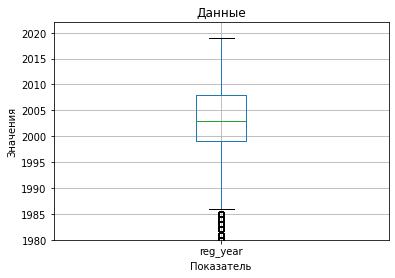

In [19]:
# визуализируем данные 
plt.title('Данные')
df[['reg_year']].boxplot()
plt.ylim(1980,2022)
plt.ylabel('Значения')
plt.xlabel('Показатель')
plt.show()

In [20]:
z = (df[(df['reg_year']<1950)|(df['reg_year']>2017)]).shape[0]
print(f'Количество строк с выбросами в поле год регистрации {z}.')

Количество строк с выбросами в поле год регистрации 4047.


In [21]:
# удалим строки с выбросами в поле registration year
df = df[(df['reg_year']>1950)&(df['reg_year']<2017)]

In [22]:
df[['reg_year']].describe()

,reg_year
count,295498.000000
mean,2002.550007
std,6.992431
min,1951.000000
25%,1999.000000
50%,2003.000000
75%,2007.000000
max,2016.000000


In [23]:
df[['power']].describe()

,power
count,295498.000000
mean,112.019821
std,198.042225
min,0.000000
25%,70.000000
50%,105.000000
75%,143.000000
max,20000.000000


In [24]:
def data_hist(df, size, title_name, bins=20, x_label='Значения', y_label='Количество'):

    """Метод Гисторамма"""
    plt.figure(figsize=size)
    plt.hist(df, bins=bins)
    plt.title(title_name)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xlim()
    plt.show

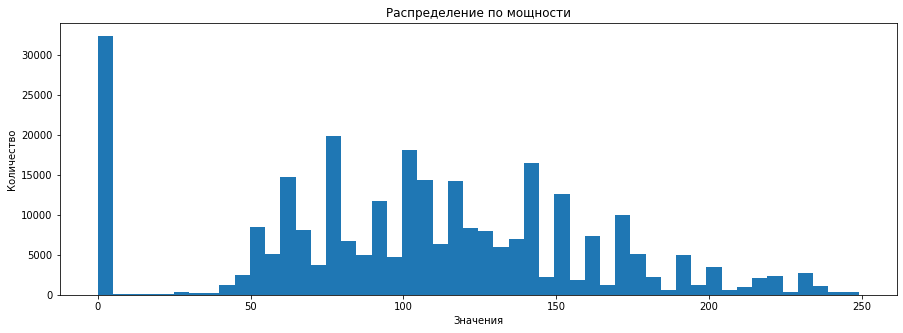

In [25]:
# Посмотрим на распределение значений 
size = (15, 5)
title_name = 'Распределение по мощности'
bins = 50

data_hist(
    df['power'][(df['power'] < 250)],
    size,
    title_name,
    bins
    )

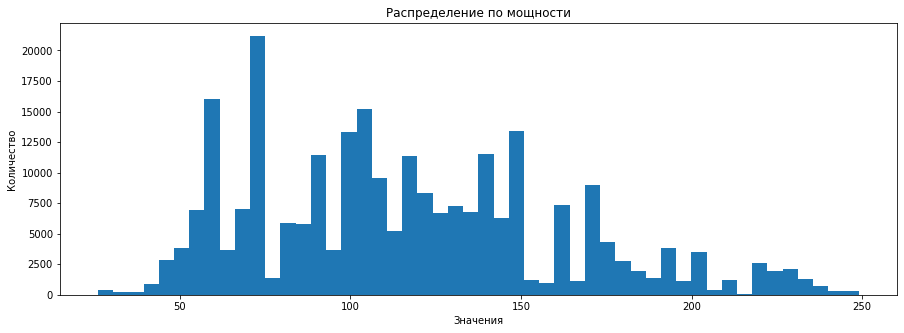

In [26]:
# Посмотрим на распределение значений 
size = (15, 5)
title_name = 'Распределение по мощности'
bins = 50

data_hist(
    df['power'][(df['power'] > 25) & (df['power'] < 250)],
    size,
    title_name,
    bins
    )

In [27]:
#проверим количество выбросов в столбце power
len(df[['power']][(df['power'] < 25) | (df['power'] > 250)])

39344

In [28]:
#удалим выбросы
df = df[(df['power'] > 25) & (df['power'] < 250)]

In [29]:
#удалим выбросы стоимости
df = df[df['price'] > 20]

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249555 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   price         249555 non-null  int64 
 1   vehicle_type  249555 non-null  object
 2   reg_year      249555 non-null  int64 
 3   gearbox       249555 non-null  object
 4   power         249555 non-null  int64 
 5   model         249555 non-null  object
 6   kilometer     249555 non-null  int64 
 7   fuel_type     249555 non-null  object
 8   brand         249555 non-null  object
 9   not_repaired  249555 non-null  object
dtypes: int64(4), object(6)
memory usage: 20.9+ MB


**ВЫВОД**

1.После предобработки данных имеем датасет из 249555 строк с 10 категориальными и 1 целевым признаком.

2.Пропуски, которые были в категориальных признаках, заменили на общие значения представленные в этих признаках.

3.Т.к признак num_photo заполнен одними нулями, удалили этот признак как лишний.

4.Избавились от аномалий в годе регистрации и мощности авто.

5.Признаки date_created, last_seen, postal_code и date_crawled удалили как лишние.


In [31]:
#КОД РЕВЬЮЕРА

df.describe()

,price,reg_year,power,kilometer
count,249555.000000,249555.000000,249555.000000,249555.000000
mean,4787.308509,2002.902715,116.804356,127193.945222
std,4531.300946,6.585129,45.089193,37405.674936
min,24.000000,1951.000000,26.000000,5000.000000
25%,1350.000000,1999.000000,77.000000,125000.000000
50%,3199.000000,2003.000000,110.000000,150000.000000
75%,6900.000000,2007.000000,144.000000,150000.000000
max,20000.000000,2016.000000,249.000000,150000.000000


## Обучение моделей

In [32]:
features_train, features_test, target_train, target_test = train_test_split(df.drop('price',axis=1),
                                                                            df['price'], test_size=0.2,
                                                                            random_state=12345)

for i in [features_train, features_test]:
    print(i.shape)

(199644, 9)
(49911, 9)


In [33]:
cat = features_train.select_dtypes('object').columns.to_list()
cat

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']

In [34]:
encoder = OrdinalEncoder(handle_unknown='ignore')

features_train_oe = features_train.copy()
features_test_oe = features_test.copy()

features_train_oe[cat] = encoder.fit_transform(features_train[cat])
features_test_oe[cat] = encoder.transform(features_test[cat])

features_train_oe.head()

,vehicle_type,reg_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
235146,7.0,2004,1.0,116,11.0,150000,2.0,2.0,0.0
232005,5.0,2010,1.0,68,54.0,60000,6.0,5.0,0.0
54316,0.0,2003,1.0,101,219.0,150000,2.0,38.0,0.0
158525,4.0,2009,1.0,140,47.0,125000,2.0,20.0,0.0
136263,4.0,1988,0.0,85,136.0,150000,6.0,22.0,0.0


**ВЫВОД**

Выделен целевой признак, данные разбиты на обучающие и тестовые выборки.

Для преобразования данных выбрали методику Original Encoding, т.к. планируем дальнейщую работу с моделями - дерево решений, случайный лес, градиентный бустинг.

Проведена стандартизация данных.

## Анализ моделей

**3.1 Случайный лес**

In [35]:
def best(model, params, features_train, target_train):
    
    grid = GridSearchCV(model, params, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
    grid.fit(features_train, target_train)
    
    rmse = -grid.best_score_ #метрика лучшей модели на кросс-валидации
    the_best_model = grid.best_estimator_ #сохраняю лучшую модель уже обученную на всей train выборке
    
    results = pd.DataFrame(grid.cv_results_)
    fit_time = results[results['rank_test_score'] == 1]['mean_fit_time'].values[0] #время обучения
    pred_time = results[results['rank_test_score'] == 1]['mean_score_time'].values[0] #время предсказания
    
    print(f'RMSE: {rmse}')
    print(f'Время обучения: {fit_time}')
    print(f'Время предсказания: {pred_time}')
    print(f'Лучшие гиперпараметры: {grid.best_params_}')
    
    return the_best_model

**DecisionTreeRegressor**

In [36]:
%%time
model_tree = DecisionTreeRegressor(random_state=42)
params_tree = {'max_depth' : range(2, 16)}

the_best_tree = best(model_tree, params_tree, features_train_oe, target_train)

RMSE: 1865.9953510179112
Время обучения: 0.38034486770629883
Время предсказания: 0.015540599822998047
Лучшие гиперпараметры: {'max_depth': 14}
CPU times: user 11.4 s, sys: 4.11 ms, total: 11.4 s
Wall time: 11.4 s


**RandomForestRegressor**

In [37]:
%%time
model_forest = RandomForestRegressor(random_state = 12345)
params_forest = {'n_estimators': range(50, 100, 50),'max_depth' : range(50, 100, 50)}

the_best_forest = best(model_forest, params_forest, features_train_oe, target_train)

RMSE: 1632.478573787236
Время обучения: 16.993233919143677
Время предсказания: 1.3024770418802898
Лучшие гиперпараметры: {'max_depth': 50, 'n_estimators': 50}
CPU times: user 1min 21s, sys: 1.26 s, total: 1min 22s
Wall time: 1min 22s


**LGBMRegressor**

In [38]:
%%time
model_lgb = lgb.LGBMRegressor(boosting_type='gbdt', random_state=12345)
params_lgb = {
    'learning_rate': np.logspace(-3, 0, 5),
    'n_estimators': [40, 60],
    'num_leaves': [31, 41, 51],
}

the_best_lgb = best(model_lgb, params_lgb, features_train_oe, target_train)

RMSE: 1601.8560449679414
Время обучения: 3.064310630162557
Время предсказания: 0.403578519821167
Лучшие гиперпараметры: {'learning_rate': 0.1778279410038923, 'n_estimators': 60, 'num_leaves': 51}
CPU times: user 4min 43s, sys: 1.47 s, total: 4min 45s
Wall time: 4min 48s


Возьмем как лучшую модель LGBMRegressor и проверим ее на тестовой выборке, потому как время от дерева решений отличается не сильно, а rmse значительно ниже.

In [41]:
%%time
model_lgb = (lgb.LGBMRegressor(boosting_type='gbdt', random_state=12345, n_estimators=60, num_leaves=51, learning_rate=0.1778279410038923)
             .fit(features_test_oe, target_test)
            )
predictions_test = model_lgb.predict(features_test_oe)
mse_test = mean_squared_error(target_test, predictions_test)
rmse_test = mse_test ** 0.5
rmse_test

CPU times: user 2.01 s, sys: 16.5 ms, total: 2.02 s
Wall time: 1.98 s


1487.0909362679563

**ВЫВОД**

Для сравнения были обучены модели DecisionTreeRegressor, RandomForest и LightGMB. Для каждой модели подготовлены входные данные. 

Самый лучший результат по метрике показал LGBMRegressor	RMSE = 1601	и временем обучения 2.4 сек

Самый лучший результат по времени показал DecisionTreeRegressor	RMSE = 1865	и временем обучения 0.3 сек

LGBMRegressor на тестовой выборке показала более лучший результат RMSE = 1487.